# 4. Finding meaning in word counts (semantic analysis)

### 4.1.3 Thought experiment

In [1]:
topic = {}
tfidf = dict(list(zip('cat dog apple lion NYC love'.split(), [1, 1, 1, 1, 1, 1])))
topic['pet'] = (.3 * tfidf['cat'] + .3 * tfidf['dog'] + 0 * tfidf['apple']
                + 0 * tfidf['lion'] - .2 * tfidf['NYC'] + .2 * tfidf['love'])
topic['animal'] = (.1 * tfidf['cat'] + .1 * tfidf['dog'] - .1 * tfidf['apple']
                   + .5 * tfidf['lion'] + .1 * tfidf['NYC'] - .1 * tfidf['love'])
topic['city'] = (0 * tfidf['cat'] - .1 * tfidf['dog'] + .2 * tfidf['apple']
                 - .1 * tfidf['lion'] + .5 * tfidf['NYC'] + .1 * tfidf['love'])

topic

{'pet': 0.6, 'animal': 0.6, 'city': 0.6}

In [2]:
word_vector = {}
word_vector['cat'] = .3 * topic['pet'] + .1 * topic['animal'] + 0 * topic['city']
word_vector['dog'] = .3 * topic['pet'] + .1 * topic['animal'] - .1 * topic['city']
word_vector['apple'] = 0 * topic['pet'] - .1 * topic['animal'] + .2 * topic['city']
word_vector['lion'] = 0 * topic['pet'] + .5 * topic['animal'] - .1 * topic['city']
word_vector['NYC'] = -.2 * topic['pet'] + .1 * topic['animal'] + .5 * topic['city']
word_vector['love'] = .2 * topic['pet'] - .1 * topic['animal'] + .1 * topic['city']

word_vector

{'cat': 0.24,
 'dog': 0.18,
 'apple': 0.06,
 'lion': 0.24,
 'NYC': 0.24,
 'love': 0.12}

### 4.1.5 An LDA classifier

In [3]:
!pip install ipdb

  Preparing metadata (setup.py) ... done
  Created wheel for ipdb: filename=ipdb-0.13.9-py3-none-any.whl size=11648 sha256=afa75a0a8d8a25fc7550ed823fc677b68688df8baa84fabe82eaf7ab3ba6a007
  Stored in directory: /home/jovyan/.cache/pip/wheels/f7/29/9a/cf774cd86e9802f075a0be1c9e0830bc062d07897b2e9e87cd
Successfully built ipdb


In [4]:
import pandas as pd
from nlpia.data.loaders import get_data
pd.options.display.width = 120  # <1>

sms = get_data('sms-spam')
index = ['sms{}{}'.format(i, '!'*j) for (i,j) in zip(range(len(sms)), sms.spam)]  # <2>
sms = pd.DataFrame(sms.values, columns=sms.columns, index=index)
mask = sms.spam.astype(bool).values
sms['spam'] = sms.spam.astype(int)

len(sms)

2022-04-26 19:55:06.348793: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-26 19:55:06.348925: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/opt/conda/lib/python3.9/site-packages/pugnlp/constants.py:136: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  [datetime.datetime, pd.datetime, pd.Timestamp])
/opt/conda/lib/python3.9/site-packages/pugnlp/constants.py:158: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  MIN_TIMESTAMP = pd.Timestamp(pd.datetime(1677, 9, 22, 0, 12, 44), tz='utc')
/opt/conda/lib/python3.9/site-packages/pugnlp/tutil.py:100: Future

Loading file with name: sms-spam


/home/jovyan/nlpia/src/nlpia/futil.py:30: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  np = pd.np
/home/jovyan/nlpia/src/nlpia/loaders.py:79: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  np = pd.np


4837

In [5]:
sms.spam.sum()

638

In [6]:
sms.head(6)

,spam,text
sms0,0,"Go until jurong point, crazy.. Available only ..."
sms1,0,Ok lar... Joking wif u oni...
sms2!,1,Free entry in 2 a wkly comp to win FA Cup fina...
sms3,0,U dun say so early hor... U c already then say...
sms4,0,"Nah I don't think he goes to usf, he lives aro..."
sms5!,1,FreeMsg Hey there darling it's been 3 week's n...


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.casual import casual_tokenize

tfidf_model = TfidfVectorizer(tokenizer=casual_tokenize)
tfidf_docs = tfidf_model.fit_transform(raw_documents=sms.text).toarray()

tfidf_docs.shape

(4837, 9232)

In [8]:
mask = sms.spam.astype(bool).values  # <1>
spam_centroid = tfidf_docs[mask].mean(axis=0) # <2>
ham_centroid = tfidf_docs[~mask].mean(axis=0)

spam_centroid.round(2), ham_centroid.round(2)

(array([0.06, 0.  , 0.  , ..., 0.  , 0.  , 0.  ]),
 array([0.02, 0.01, 0.  , ..., 0.  , 0.  , 0.  ]))

In [9]:
spamminess_score = tfidf_docs.dot(spam_centroid - ham_centroid)
spamminess_score.round(2)

array([-0.01, -0.02,  0.04, ..., -0.01, -0.  ,  0.  ])

In [10]:
from sklearn.preprocessing import MinMaxScaler
sms['lda_score'] = MinMaxScaler().fit_transform(spamminess_score.reshape(-1,1))
sms['lda_predict'] = (sms.lda_score > .5).astype(int)

sms['spam lda_predict lda_score'.split()].round(2).head(6)

,spam,lda_predict,lda_score
sms0,0,0,0.23
sms1,0,0,0.18
sms2!,1,1,0.72
sms3,0,0,0.18
sms4,0,0,0.29
sms5!,1,1,0.55


In [11]:
(1. - (sms.spam - sms.lda_predict).abs().sum() / len(sms)).round(3)

0.977

In [12]:
from pugnlp.stats import Confusion

Confusion(sms['spam lda_predict'.split()])

/opt/conda/lib/python3.9/site-packages/pugnlp/stats.py:25: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  np = pd.np
/opt/conda/lib/python3.9/site-packages/pugnlp/stats.py:504: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.__setattr__('_hist_labels', self.sum().astype(int))
/opt/conda/lib/python3.9/site-packages/pugnlp/stats.py:510: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  setattr(self, '_hist_classes', self.T.sum())
/opt/conda/lib/python3.9/site-packages/pugnlp/stats.py:513: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  setattr(self, '_tp'

lda_predict,0,1
spam,,
0,4135,64
1,45,593


### 4.2.1 Your thought experiment made real

In [13]:
from nlpia.book.examples.ch04_catdog_lsa_3x6x16\
    import word_topic_vectors
word_topic_vectors.T.round(1)

Loading file with name: cats_and_dogs_sorted


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 484879.98it/s]


,cat,dog,apple,lion,nyc,love
top0,-0.6,-0.4,0.5,-0.3,0.4,-0.1
top1,-0.1,-0.3,-0.4,-0.1,0.1,0.8
top2,-0.3,0.8,-0.1,-0.5,0.0,0.1


## 4.3 Singular value decomposition

In [14]:
from nlpia.book.examples.ch04_catdog_lsa_sorted import lsa_models, prettify_tdm

bow_svd, tfidf_svd = lsa_models()  # <1>
prettify_tdm(**bow_svd)

Loading file with name: cats_and_dogs_sorted


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 496445.52it/s]


Loading file with name: cats_and_dogs_sorted


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 369424.63it/s]


,cat,dog,apple,lion,nyc,love,text
0,,,1,,1,,NYC is the Big Apple.
1,,,1,,1,,NYC is known as the Big Apple.
2,,,,,1,1,I love NYC!
3,,,1,,1,,I wore a hat to the Big Apple party in NYC.
4,,,1,,1,,Come to NYC. See the Big Apple!
5,,,1,,,,Manhattan is called the Big Apple.
6,1,,,,,,New York is a big city for a small cat.
7,1,,,1,,,"The lion, a big cat, is the king of the jungle."
8,1,,,,,1,I love my pet cat.
9,,,,,1,1,I love New York City (NYC).


In [15]:
tdm = bow_svd['tdm'] 
tdm

,0,1,2,3,4,5,6,7,8,9,10
cat,0,0,0,0,0,0,1,1,1,0,1
dog,0,0,0,0,0,0,0,0,0,0,1
apple,1,1,0,1,1,1,0,0,0,0,0
lion,0,0,0,0,0,0,0,1,0,0,0
nyc,1,1,1,1,1,0,0,0,0,1,0
love,0,0,1,0,0,0,0,0,1,1,0


### 4.3.1 U--left singular vectors

In [16]:
import numpy as np
import pandas as pd

u, s, vt = np.linalg.svd(tdm)
pd.DataFrame(u, index=tdm.index).round(2)

,0,1,2,3,4,5
cat,-0.04,0.83,-0.38,-0.00,0.11,-0.38
dog,-0.00,0.21,-0.18,-0.71,-0.39,0.52
apple,-0.62,-0.21,-0.51,0.00,0.49,0.27
lion,-0.00,0.21,-0.18,0.71,-0.39,0.52
nyc,-0.75,-0.00,0.24,-0.00,-0.52,-0.32
love,-0.22,0.42,0.69,0.00,0.41,0.37


### 4.3.2 S--singular vectors

In [17]:
s.round(1)

array([3.1, 2.2, 1.8, 1. , 0.8, 0.5])

In [18]:
S = np.zeros((len(u), len(vt)))
pd.np.fill_diagonal(S, s)
pd.DataFrame(S).round(1)

/tmp/ipykernel_53/4097854748.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  pd.np.fill_diagonal(S, s)


,0,1,2,3,4,5,6,7,8,9,10
0,3.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0


### 4.3.3 V<sup>t</sup>--right singular values

In [19]:
pd.DataFrame(vt).round(2)

,0,1,2,3,4,5,6,7,8,9,10
0,-0.44,-0.44,-0.31,-0.44,-0.44,-0.20,-0.01,-0.01,-0.08,-0.31,-0.01
1,-0.09,-0.09,0.19,-0.09,-0.09,-0.09,0.37,0.47,0.56,0.19,0.47
2,-0.16,-0.16,0.52,-0.16,-0.16,-0.29,-0.22,-0.32,0.17,0.52,-0.32
3,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.71,0.00,-0.00,-0.71
4,-0.04,-0.04,-0.14,-0.04,-0.04,0.58,0.13,-0.33,0.62,-0.14,-0.33
5,-0.09,-0.09,0.10,-0.09,-0.09,0.51,-0.73,0.27,-0.01,0.10,0.27
6,-0.57,0.21,0.11,0.33,-0.31,0.34,0.34,0.00,-0.34,0.23,0.00
7,-0.32,0.47,0.25,-0.63,0.41,0.07,0.07,0.00,-0.07,-0.18,0.00
8,-0.50,0.29,-0.20,0.41,0.16,-0.37,-0.37,-0.00,0.37,-0.17,0.00
9,-0.15,-0.15,-0.59,-0.15,0.42,0.04,0.04,-0.00,-0.04,0.63,-0.00


### 4.3.5 Truncating the topics

In [20]:
err = []
for numdim in range(len(s), 0, -1):
    S[numdim - 1, numdim - 1] = 0
    reconstructed_tdm = u.dot(S).dot(vt)
    err.append(np.sqrt(((\
                         reconstructed_tdm - tdm).values.flatten() ** 2).sum()
                       / np.product(tdm.shape)))

np.array(err).round(2)

array([0.06, 0.12, 0.17, 0.28, 0.39, 0.55])

[0.06422633791023077, 0.12203397231758811, 0.17333149036203727, 0.27859482227696736, 0.39162820475179105, 0.5504818825631803]


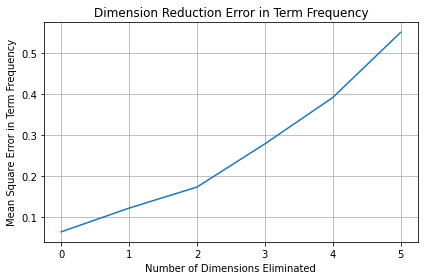

In [21]:
from matplotlib import pyplot as plt

plt.plot(range(len(err)), err)
plt.title('Dimension Reduction Error in Term Frequency')
plt.xlabel('Number of Dimensions Eliminated')
plt.ylabel('Mean Square Error in Term Frequency')
plt.grid('on')
plt.tight_layout()
print(err)
# plt.show()

### 4.4.1 PCA on 3D vectors

Loading file with name: pointcloud


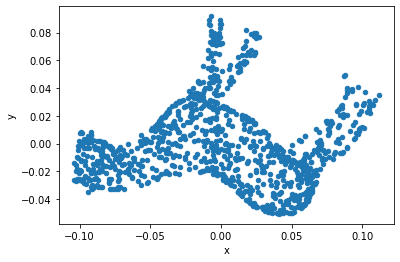

In [22]:
from sklearn.decomposition import PCA
import seaborn

df = get_data('pointcloud').sample(1000)
pca = PCA(n_components=2)
df2d = pd.DataFrame(pca.fit_transform(df), columns=list('xy'))
df2d.plot(kind='scatter', x='x', y='y')
plt.show()

### 4.4.2 Stop horsing around and get back to NLP

In [23]:
index = ['sms{}{}'.format(i, '!' * j) for (i, j) in
         zip(range(len(sms)), sms.spam)]  # <2>

sms.index = index
sms.head(6)

,spam,text,lda_score,lda_predict
sms0,0,"Go until jurong point, crazy.. Available only in bu...",0.227478,0
sms1,0,Ok lar... Joking wif u oni...,0.177888,0
sms2!,1,Free entry in 2 a wkly comp to win FA Cup final tkt...,0.718785,1
sms3,0,U dun say so early hor... U c already then say...,0.184565,0
sms4,0,"Nah I don't think he goes to usf, he lives around h...",0.286944,0
sms5!,1,FreeMsg Hey there darling it's been 3 week's now an...,0.548003,1


In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import casual_tokenize

tfidf_model = TfidfVectorizer(tokenizer=casual_tokenize)
tfidf_docs = tfidf_model.fit_transform(raw_documents=sms.text).toarray()

len(tfidf_model.vocabulary_)

9232

In [25]:
tfidf_docs.shape

(4837, 9232)

In [26]:
sms.spam.sum()

638

### 4.4.3 Using PCA for SMS message semantic analysis

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=16)
pca = pca.fit(tfidf_docs)
pca_topic_vectors = pca.transform(tfidf_docs)

columns = ['topic{}'.format(i) for i in range(pca.n_components)]

pca_topic_vectors = pd.DataFrame(pca_topic_vectors, columns=columns, index=index)
pca_topic_vectors.round(3).head(6)

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13,topic14,topic15
sms0,0.201,0.003,0.037,0.011,-0.019,-0.053,0.039,-0.066,0.011,-0.082,0.006,0.003,-0.020,-0.026,-0.011,-0.025
sms1,0.404,-0.094,-0.078,0.051,0.100,0.047,0.023,0.065,0.023,-0.023,-0.003,-0.032,-0.044,-0.005,0.051,0.043
sms2!,-0.030,-0.048,0.090,-0.067,0.091,-0.043,-0.000,-0.001,-0.057,0.052,0.124,-0.026,-0.031,-0.014,-0.043,-0.038
sms3,0.329,-0.033,-0.035,-0.016,0.052,0.056,-0.166,-0.075,0.062,-0.106,0.022,-0.019,-0.088,-0.015,0.030,0.057
sms4,0.002,0.031,0.038,0.034,-0.075,-0.093,-0.043,0.060,-0.045,0.029,0.028,0.006,-0.021,0.056,-0.066,0.030
sms5!,-0.016,0.059,0.014,-0.006,0.122,-0.040,0.005,0.167,-0.022,0.065,0.039,-0.053,0.057,0.065,0.002,-0.041


In [28]:
tfidf_model.vocabulary_

{'go': 3807,
 'until': 8487,
 'jurong': 4675,
 'point': 6296,
 ',': 13,
 'crazy': 2549,
 '..': 21,
 'available': 1531,
 'only': 5910,
 'in': 4396,
 'bugis': 1973,
 'n': 5594,
 'great': 3894,
 'world': 8977,
 'la': 4811,
 'e': 3056,
 'buffet': 1971,
 '...': 25,
 'cine': 2277,
 'there': 8071,
 'got': 3855,
 'amore': 1296,
 'wat': 8736,
 'ok': 5874,
 'lar': 4848,
 'joking': 4642,
 'wif': 8875,
 'u': 8395,
 'oni': 5906,
 'free': 3604,
 'entry': 3195,
 '2': 471,
 'a': 1054,
 'wkly': 8933,
 'comp': 2386,
 'to': 8192,
 'win': 8890,
 'fa': 3328,
 'cup': 2608,
 'final': 3450,
 'tkts': 8180,
 '21st': 497,
 'may': 5272,
 '2005': 487,
 '.': 15,
 'text': 8020,
 '87121': 948,
 'receive': 6688,
 'question': 6574,
 '(': 9,
 'std': 7651,
 'txt': 8379,
 'rate': 6628,
 ')': 10,
 't': 7889,
 '&': 7,
 "c's": 2020,
 'apply': 1383,
 '08452810075': 115,
 'over': 6003,
 '18': 438,
 "'": 8,
 's': 6959,
 'dun': 3041,
 'say': 7034,
 'so': 7438,
 'early': 3069,
 'hor': 4207,
 'c': 2019,
 'already': 1268,
 'then': 

In [29]:
column_nums, terms = zip(*sorted(zip(tfidf_model.vocabulary_.values(), tfidf_model.vocabulary_.keys())))

terms[:15]

('!',
 '"',
 '#',
 '#150',
 '#5000',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-')

In [30]:
weights = pd.DataFrame(pca.components_, columns=terms, index=['topic{}'.format(i) for i in range(16)])

pd.options.display.max_columns = 8

weights.head(4).round(3)

,!,"""",#,#150,...,…,┾,〨ud,鈥
topic0,-0.071,0.008,-0.001,-0.000,...,-0.002,0.001,0.001,0.001
topic1,0.064,0.008,0.000,-0.000,...,0.003,0.001,0.001,0.001
topic2,0.071,0.027,0.000,0.001,...,0.002,-0.001,-0.001,-0.001
topic3,-0.059,-0.032,-0.001,-0.000,...,0.001,0.000,0.000,0.000


In [31]:
pd.options.display.max_columns = 12

deals = weights['! ;) ;) half off free crazy deal only $ 80 %'.split()].round(3) * 100

deals

,!,;),;),half,off,free,crazy,deal,only,$,80,%
topic0,-7.1,0.1,0.1,-0.0,-0.4,-2.0,-0.0,-0.1,-2.2,0.3,-0.0,-0.0
topic1,6.4,0.0,0.0,0.1,0.4,-2.3,-0.2,-0.1,-3.8,-0.1,-0.0,-0.2
topic2,7.1,0.2,0.2,0.0,0.3,4.4,0.1,-0.1,0.7,0.0,0.0,0.1
topic3,-5.9,-0.3,-0.3,0.2,0.3,-0.2,0.0,0.1,-2.3,0.1,-0.1,-0.3
topic4,38.1,-0.1,-0.1,-0.1,-0.2,9.9,0.1,-0.2,3.0,0.3,0.1,-0.1
topic5,-26.5,0.1,0.1,-0.3,-0.7,-1.4,-0.6,-0.2,-1.8,-0.9,0.0,0.0
topic6,-10.9,-0.5,-0.5,-0.4,-0.9,-0.6,-0.2,-0.1,-1.4,-0.0,-0.0,-0.1
topic7,16.1,0.1,0.1,0.8,0.8,-2.7,0.0,0.1,-1.8,-0.3,0.0,-0.1
topic8,34.5,0.1,0.1,-0.4,-0.5,0.3,-0.4,-0.4,3.2,-0.6,-0.0,-0.2
topic9,7.4,-0.3,-0.3,1.4,-0.9,6.3,-0.5,-0.4,3.1,-0.5,-0.0,-0.0


In [32]:
deals.T.sum()

topic0    -11.3
topic1      0.2
topic2     13.0
topic3     -8.7
topic4     50.7
topic5    -32.2
topic6    -15.6
topic7     13.1
topic8     35.7
topic9     15.3
topic10   -20.2
topic11   -18.8
topic12    27.8
topic13     7.2
topic14     2.5
topic15    -3.8
dtype: float64

### 4.4.4 Using truncated SVD for SMS message semantic analysis

In [33]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=16, n_iter=300)  # <1>
svd_topic_vectors = svd.fit_transform(tfidf_docs)  # <2>
svd_topic_vectors = pd.DataFrame(svd_topic_vectors, columns=columns, index=index)
svd_topic_vectors.round(3).head(6)

,topic0,topic1,topic2,topic3,topic4,topic5,...,topic10,topic11,topic12,topic13,topic14,topic15
sms0,0.117,0.197,0.001,0.047,0.030,0.023,...,-0.018,-0.003,0.008,0.005,-0.036,-0.045
sms1,0.111,0.421,-0.089,0.001,0.005,-0.096,...,-0.032,-0.017,-0.035,0.043,-0.023,0.071
sms2!,0.116,-0.047,-0.053,0.019,0.102,-0.074,...,0.141,-0.042,-0.024,0.029,-0.013,-0.068
sms3,0.136,0.343,-0.030,-0.003,0.120,-0.011,...,-0.069,-0.081,-0.029,0.078,-0.037,0.073
sms4,0.118,-0.002,0.029,0.049,-0.027,0.068,...,0.020,-0.044,0.001,0.031,0.054,-0.029
sms5!,0.228,0.003,0.058,0.022,0.080,-0.106,...,0.066,0.015,-0.049,-0.044,0.068,-0.021


### 4.4.5 How well does LSA work for spam classification?

In [34]:
svd_topic_vectors = (svd_topic_vectors.T / np.linalg.norm(svd_topic_vectors, axis=1)).T  # <1>
svd_topic_vectors.iloc[:10].dot(svd_topic_vectors.iloc[:10].T).round(1)

,sms0,sms1,sms2!,sms3,sms4,sms5!,sms6,sms7,sms8!,sms9!
sms0,1.0,0.7,0.2,0.7,0.2,0.1,0.1,0.0,0.1,0.0
sms1,0.7,1.0,-0.0,0.8,-0.0,0.2,0.1,-0.0,0.0,0.1
sms2!,0.2,-0.0,1.0,0.0,0.3,0.6,0.3,0.4,0.6,0.5
sms3,0.7,0.8,0.0,1.0,0.0,0.0,0.2,-0.1,0.0,0.1
sms4,0.2,-0.0,0.3,0.0,1.0,0.5,0.3,0.2,0.0,0.1
sms5!,0.1,0.2,0.6,0.0,0.5,1.0,0.4,0.4,0.5,0.6
sms6,0.1,0.1,0.3,0.2,0.3,0.4,1.0,0.4,0.2,0.2
sms7,0.0,-0.0,0.4,-0.1,0.2,0.4,0.4,1.0,0.4,0.7
sms8!,0.1,0.0,0.6,0.0,0.0,0.5,0.2,0.4,1.0,0.5
sms9!,0.0,0.1,0.5,0.1,0.1,0.6,0.2,0.7,0.5,1.0


### 4.5.1 The LDiA idea

In [35]:
total_corpus_len = 0

for document_text in sms.text:
    total_corpus_len += len(casual_tokenize(document_text))
    
mean_document_len = total_corpus_len / len(sms)

round(mean_document_len, 2)

21.35

In [36]:
sum([len(casual_tokenize(t)) for t in sms.text]) * 1. / len(sms.text)

21.34794293983874

### 4.5.2 LDiA topic model for SMS messages

In [37]:
counter = CountVectorizer(tokenizer=casual_tokenize)
bow_docs = pd.DataFrame(counter.fit_transform(raw_documents=sms.text).toarray(), index=index)
column_nums, terms = zip(*sorted(zip(counter.vocabulary_.values(), counter.vocabulary_.keys())))
bow_docs.columns = terms

bow_docs

,!,"""",#,#150,#5000,$,...,’,“,…,┾,〨ud,鈥
sms0,0,0,0,0,0,0,...,0,0,0,0,0,0
sms1,0,0,0,0,0,0,...,0,0,0,0,0,0
sms2!,0,0,0,0,0,0,...,0,0,0,0,0,0
sms3,0,0,0,0,0,0,...,0,0,0,0,0,0
sms4,0,0,0,0,0,0,...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
sms4832!,1,0,0,0,0,0,...,0,0,0,0,0,0
sms4833,0,0,0,0,0,0,...,0,0,0,0,0,0
sms4834,0,0,0,0,0,0,...,0,0,0,0,0,0
sms4835,0,0,0,0,0,0,...,0,0,0,0,0,0


In [38]:
sms.loc['sms0'].text

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [40]:
bow_docs.loc['sms0'][bow_docs.loc['sms0'] > 0].head()

,            1
..           1
...          2
amore        1
available    1
Name: sms0, dtype: int64

In [41]:
from sklearn.decomposition import LatentDirichletAllocation as LDiA

ldia = LDiA(n_components=16, learning_method='batch')
ldia = ldia.fit(bow_docs)  # <1>
ldia.components_.shape

(16, 9232)

In [42]:
pd.set_option('display.width', 75)

components = pd.DataFrame(ldia.components_.T, index=terms, columns=columns)
components.round(2).head()

,topic0,topic1,topic2,topic3,topic4,topic5,...,topic10,topic11,topic12,topic13,topic14,topic15
!,101.67,230.72,300.51,86.40,21.26,0.06,...,45.96,0.06,5.36,182.87,21.49,51.88
"""",0.06,16.23,27.16,0.06,0.06,10.47,...,0.06,0.06,124.24,0.06,0.06,20.22
#,2.19,0.06,2.67,2.32,0.06,0.06,...,0.06,0.06,0.06,0.06,0.06,0.06
#150,0.06,0.06,0.06,0.06,0.06,0.06,...,0.06,0.06,0.06,0.06,0.06,1.06
#5000,0.06,0.06,0.06,0.06,0.06,3.06,...,0.06,0.06,0.06,0.06,0.06,0.06


In [43]:
components.topic3.sort_values(ascending=False)[:10]

.      181.279010
u      134.610054
to     109.498328
the    108.487500
,       86.608736
!       86.399490
2       76.633940
a       64.854003
on      58.257008
out     52.752877
Name: topic3, dtype: float64

In [44]:
ldia16_topic_vectors = ldia.transform(bow_docs)
ldia16_topic_vectors = pd.DataFrame(ldia16_topic_vectors,\
    index=index, columns=columns)
ldia16_topic_vectors.round(2).head()

,topic0,topic1,topic2,topic3,topic4,topic5,...,topic10,topic11,topic12,topic13,topic14,topic15
sms0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00
sms1,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.17
sms2!,0.00,0.38,0.00,0.00,0.00,0.00,...,0.42,0.00,0.00,0.00,0.00,0.00
sms3,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.24,0.00,0.00,0.00,0.31
sms4,0.00,0.00,0.23,0.00,0.00,0.00,...,0.00,0.62,0.00,0.00,0.00,0.00


### 4.5.3 LDiA + LDA = spam classifier

In [49]:
from sklearn.model_selection import train_test_split 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

X_train, X_test, y_train, y_test = train_test_split(pca_topic_vectors, sms.spam.astype(int), test_size=0.5, random_state=271828)
lda = LDA(n_components=1)
lda = lda.fit(X_train, y_train)
sms['pca16_spam'] = lda.predict(pca_topic_vectors)
round(float(lda.score(X_test, y_test)), 3)

0.964

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.casual import casual_tokenize

tfidf_model = TfidfVectorizer(tokenizer=casual_tokenize)
tfidf_docs = tfidf_model.fit_transform(\
    raw_documents=sms.text).toarray()
tfidf_docs.shape

(4837, 9232)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_docs, sms.spam.astype(int), test_size=0.5, random_state=271828)

lda = LDA(n_components=1)
lda = lda.fit(X_train, y_train)

print(round(float(lda.score(X_train, y_train)), 3))
print(round(float(lda.score(X_test, y_test)), 3))

1.0
0.969


### 4.5.4 A fairer comparison: 32 LDiA topics

In [53]:
ldia32 = LDiA(n_components=32, learning_method="batch")
ldia32 = ldia32.fit(bow_docs)
ldia32.components_.shape

(32, 9232)

In [58]:
ldia32_topic_vectors = ldia32.transform(bow_docs)
columns32 = ["topic{}".format(i) for i in range(ldia32.n_components)]

ldia32_topic_vectors.shape, len(columns32), len(index)

((4837, 32), 32, 4837)

In [59]:
ldia32_topic_vectors = pd.DataFrame(ldia32_topic_vectors, index=index, columns=columns32)

ldia32_topic_vectors.round(2).head()

,topic0,topic1,topic2,topic3,topic4,topic5,...,topic26,topic27,topic28,topic29,topic30,topic31
sms0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.00
sms1,0.89,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.00
sms2!,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.98,0.0,0.0,0.00
sms3,0.53,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.08
sms4,0.00,0.0,0.5,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.00


In [60]:
X_train, X_test, y_train, y_test = train_test_split(ldia32_topic_vectors, sms.spam, test_size=0.5, random_state=271828)

lda = LDA(n_components=1)
lda = lda.fit(X_train, y_train)

sms['ldia32_spam'] = lda.predict(ldia32_topic_vectors)

print(round(float(lda.score(X_train, y_train)), 3))
print(round(float(lda.score(X_test, y_test)), 3))

0.94
0.941


### 4.7.1 Linear discriminant analysis

In [61]:
lda = LDA(n_components=1)
lda = lda.fit(tfidf_docs, sms.spam)

sms["lda_spamminess"] = lda.predict(tfidf_docs)

((sms.spam - sms.lda_spamminess) ** 2.).sum() ** .5

0.0

In [62]:
(sms.spam == sms.lda_spamminess).sum()

4837

In [63]:
len(sms)

4837

In [65]:
from sklearn.model_selection import cross_val_score

lda = LDA(n_components=1)

scores = cross_val_score(lda, tfidf_docs, sms.spam, cv=5)

"Accuracy: {:.2f} (+/-{:.2f})".format(scores.mean(), scores.std() * 2)

'Accuracy: 0.96 (+/-0.01)'

In [66]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_docs, sms.spam, test_size=0.33, random_state=271828)

lda = LDA(n_components=1)
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=1)

In [67]:
lda.score(X_test, y_test).round(3)

0.965

In [68]:
X_train, X_test, y_train, y_test = train_test_split(pca_topic_vectors.values, sms.spam, test_size=0.3, random_state=271828)

lda = LDA(n_components=1)
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=1)

In [69]:
lda.score(X_test, y_test).round(3)

0.962

In [70]:
lda = LDA(n_components=1)

scores = cross_val_score(lda, pca_topic_vectors, sms.spam, cv=10)

"Accuracy: {:.3f} (+/-{:.3f})".format(scores.mean(), scores.std() * 2)

'Accuracy: 0.956 (+/-0.022)'